In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('ZIKABR17.csv')
df.head()

,TP_NOT,ID_AGRAVO,CS_SUSPEIT,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,DT_SIN_PRI,...,COPAISINF,COMUNINF,DOENCA_TRA,EVOLUCAO,DT_OBITO,DT_ENCERRA,CS_FLXRET,FLXRECEBI,TP_SISTEMA,TPUNINOT
0,2,A928,NaN,2017-04-01,201713,2017,51,510840,1578.0,2017-03-31,...,0,NaN,NaN,1.0,NaN,2017-09-27,0,2,1,NaN
1,2,A928,NaN,2017-04-01,201713,2017,35,350950,1342.0,2017-04-01,...,0,NaN,NaN,NaN,NaN,2017-08-31,0,2,1,NaN
2,2,A928,NaN,2017-04-01,201713,2017,26,260790,1497.0,2017-03-31,...,0,NaN,NaN,1.0,NaN,2017-05-25,0,2,1,NaN
3,2,A928,NaN,2017-04-01,201713,2017,51,510340,1578.0,2017-03-31,...,1,510340.0,2.0,1.0,NaN,2017-07-17,0,2,1,NaN
4,2,A928,NaN,2017-04-01,201713,2017,51,510340,1578.0,2017-03-31,...,0,NaN,NaN,NaN,NaN,2017-06-06,0,2,1,NaN


In [ ]:
df = df.groupby('DT_NOTIFIC').count().reset_index()
df.rename(columns={'DT_NOTIFIC':"Data", 'TP_NOT':'Casos'}, inplace= True)
df = df[['Data','Casos']]
df['Data'] = pd.to_datetime(df['Data'])

# 1. Sazonalidade



In [ ]:
PERIODS = {
    "Y": 'Ano',
    "b": 'Mês',
    "d": 'Dia',
    "H": "Hora",
    "M": "Minuto",
}

MONTHS = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

def format_dates(dataframe, date_column, period, default_period):
    """
    Formats dates in a DataFrame according to the specified period.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        date_column (str): The name of the date column.
        period (str): The desired formatting period (e.g., "Y" for year, "b" for month).
        default_period (str): The default format to be used if the period is not recognized.

    Returns:
        pd.Series: A series with the formatted dates.
    """
    dataframe[date_column] = pd.to_datetime(dataframe[date_column])
    periodo_mapping = {"Y": "%Y", "b": "%b", "d": "%d", "H": "%H", "M": "%M"}
    return dataframe[date_column].dt.strftime(periodo_mapping.get(period, default_period))

def plot_seasonality(dataframe, date_column, value_column, grouping_period, observation_period, title=""):
    """
    Creates a seasonal plot from a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        date_column (str): The name of the date column.
        value_column (str): The name of the column with the values to be plotted.
        grouping_period (str): The grouping period (e.g., "Y" for year, "b" for month).
        observation_period (str): The observation period (e.g., "Y" for year, "b" for month).
        title (str): The title of the plot.

    """
    df = dataframe.copy()
    grouping_period_label = PERIODS.get(grouping_period, "%b")
    observation_period_label = PERIODS.get(observation_period, "%Y")

    df[grouping_period_label] = format_dates(df, date_column, grouping_period, '%b')
    df[observation_period_label] = format_dates(df, date_column, observation_period, '%Y')

    palette = sns.color_palette("Set2", len(df[observation_period_label].unique()))
    g = sns.relplot(data=df, x=grouping_period_label, y=value_column, hue=observation_period_label, kind="line", palette=palette, height=5.5)

    plt.title(title, fontweight='bold', fontsize=14)
    plt.ylabel(value_column)

    # Configure x-axis ticks (if it's monthly)
    if grouping_period == "b":
        plt.xticks(range(12), MONTHS)

    sns.set(style='darkgrid')
    plt.grid(True, alpha=0.6)
    plt.show()

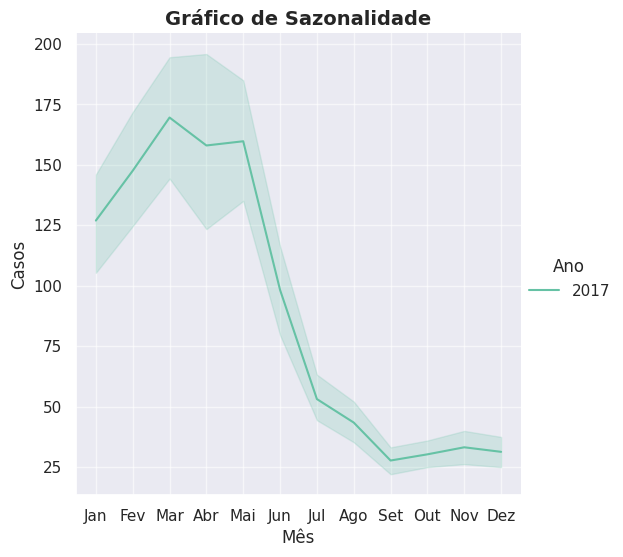

In [ ]:
plot_seasonality(df, 'Data', "Casos", 'b', 'Y', title='Gráfico de Sazonalidade')

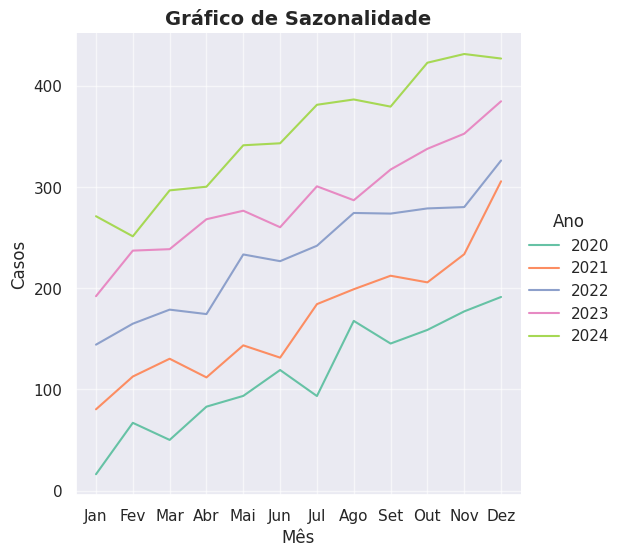

In [ ]:
# Exemplo:
data = pd.date_range(start='2020-01-01', periods=60, freq='M')
value = [30 + 5 * i + 10 * (i % 12) + np.random.normal(0, 15) for i in range(60)]
df = pd.DataFrame({'Data': data, 'Casos': value})

plot_seasonality(df, 'Data', "Casos", 'b', 'Y', title='Gráfico de Sazonalidade')

# 2. Sub-Séries

In [ ]:
def plot_subseries(dataframe, date_column, value_column, title="Month Plot"):
    """
    Create subplots for a time series DataFrame with monthly highlights.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the time series data.
        date_column (str): The name of the date column.
        value_column (str): The name of the column with the time series values.
        title (str): The title of the subplots.
    """
    # Ensure the DataFrame is sorted by date
    dataframe = dataframe.sort_values(by=date_column)

    # Convert the date column to datetime and set it as the index
    dataframe[date_column] = pd.to_datetime(dataframe[date_column])
    dataframe.set_index(date_column, inplace=True)

    # Resample data to monthly frequency using mean
    if dataframe.index.freq != 'M':
        dataframe = dataframe.resample('M').mean()

    # Create the time series
    ts = dataframe[value_column]

    # Create subplots for each month
    sm.graphics.tsa.month_plot(ts)
    plt.title(title, fontweight='bold', fontsize=14)
    print(ts)
    print(type(ts))
    plt.show()

Data
2017-01-31    126.903226
2017-02-28    147.500000
2017-03-31    169.483871
2017-04-30    157.933333
2017-05-31    159.677419
2017-06-30     98.233333
2017-07-31     53.129032
2017-08-31     43.419355
2017-09-30     27.733333
2017-10-31     30.290323
2017-11-30     33.200000
2017-12-31     31.322581
Freq: M, Name: Casos, dtype: float64
<class 'pandas.core.series.Series'>


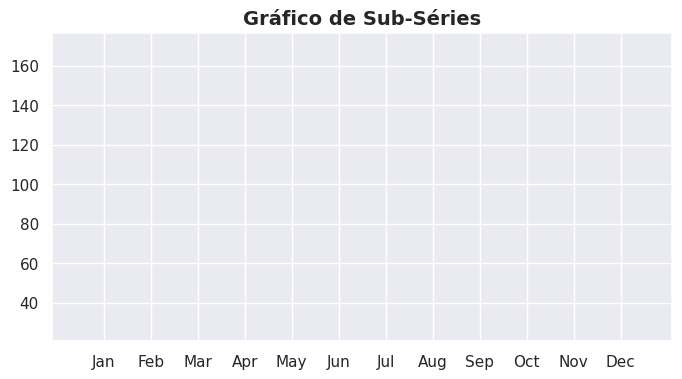

In [ ]:
plot_subseries(df, 'Data', 'Casos', title='Gráfico de Sub-Séries')

 Gráfico não informativo pois nesse conjunto só estamos analisando 1 ano (2017). Abaixo temos um exemplo hipotético:

date
2010-01-31     0.808140
2010-02-28     1.973945
2010-03-31     0.853943
2010-04-30     2.393214
2010-05-31     1.204557
                ...    
2019-08-31    23.334325
2019-09-30    24.014573
2019-10-31    24.757288
2019-11-30    24.670257
2019-12-31    26.170696
Freq: M, Name: value, Length: 120, dtype: float64
<class 'pandas.core.series.Series'>


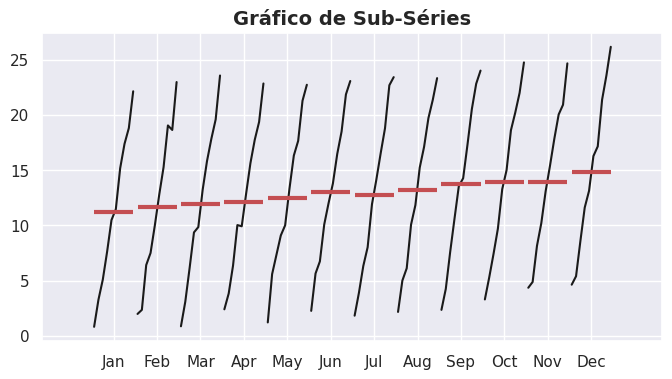

In [ ]:
# Exaemplo:
date_range = pd.date_range(start='2010-01-01', periods=120, freq='MS')
data = {'date': date_range, 'value': [0.5 + 0.2 * i + 0.1 * (i % 12) + np.random.normal(0, 0.7) for i in range(120)]}
df = pd.DataFrame(data)
plot_subseries(df, 'date', 'value', title='Gráfico de Sub-Séries')

# 3. Multi-sazonalidade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv("ZIKABR17.csv")
df['DT_NOTIFIC']

0        2017-04-01
1        2017-04-01
2        2017-04-01
3        2017-04-01
4        2017-04-01
            ...    
32679    2017-03-31
32680    2017-03-31
32681    2017-03-31
32682    2017-03-31
32683    2017-03-31
Name: DT_NOTIFIC, Length: 32684, dtype: object

In [ ]:
df = df.groupby('DT_NOTIFIC').count().reset_index()
df.rename(columns={'DT_NOTIFIC':"Data", 'TP_NOT':'Casos'}, inplace= True)
df = df[['Data','Casos']]
df['Data'] = pd.to_datetime(df['Data'])

In [ ]:
df.head()

,Data,Casos
0,2017-01-01,17
1,2017-01-02,98
2,2017-01-03,136
3,2017-01-04,130
4,2017-01-05,112


In [ ]:
def sazonalidade_semanal(data, y):
  df['day_of_week'] = data.dt.day_name()
  plt.figure(figsize=(15,4))
  plt.plot(list(df['day_of_week']),y,'tab:red')
  plt.show()

def sazonalidade_mensal(data, y):
  df['meses'] = data.dt.month
  plt.figure(figsize=(15,4))
  plt.plot(list(df['meses']),df['Casos'],'tab:red')
  plt.show()

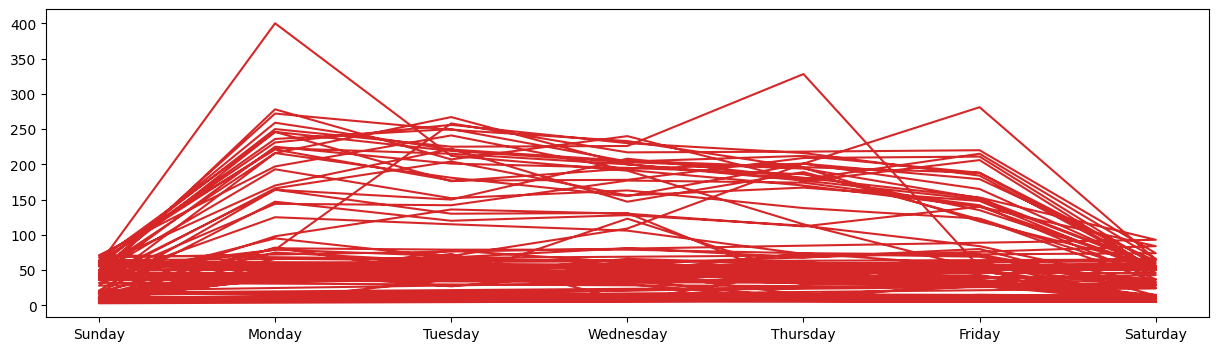

In [ ]:
sazonalidade_semanal(df['Data'], df['Casos'])

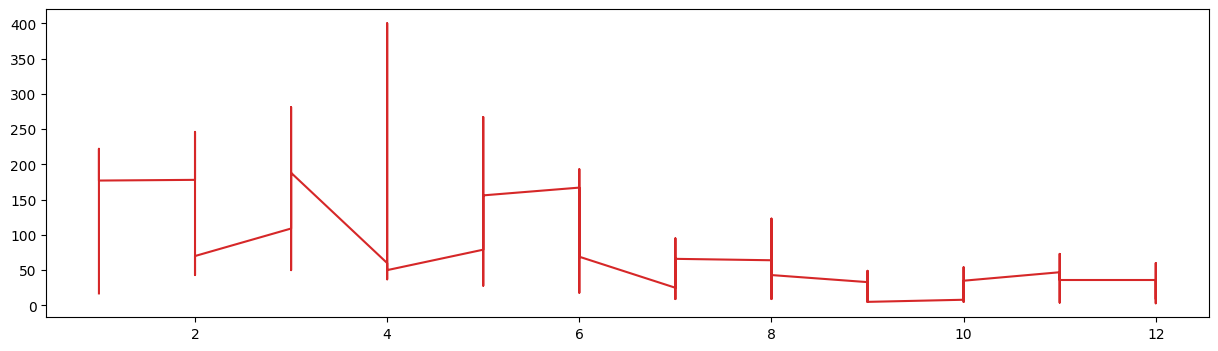

In [ ]:
sazonalidade_mensal(df['Data'], df['Casos'])

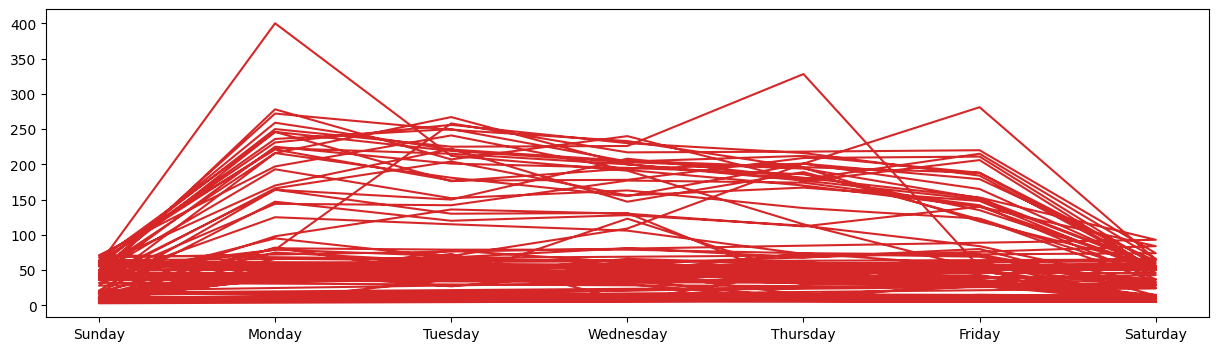

In [ ]:
plt.figure(figsize=(15,4))
# plot_series(df['day_of_week'], transformed_data, f"Casos de Zika em 2017 (Lambda = {x})")
plt.plot(list(df['day_of_week']),df['Casos'],'tab:red')
plt.show()

# 4. Defasagens

In [ ]:
def plot_defasagens(num_lags, num_colunas, data, y):
  Tot = num_lags
  Cols = num_colunas

  # Linhas necessárias
  Rows = Tot // Cols
  if Tot % Cols != 0:
      Rows += 1

  # Criando índice para posição no plot

  Position = range(1,Tot + 1)
  # Figura principal
  fig = plt.figure(1,figsize=(num_lags*num_colunas,num_lags+num_colunas))
  for k in range(Tot):
    # Adicionando cada subplot
    ax = fig.add_subplot(Rows,Cols,Position[k])
    pd.plotting.lag_plot(y, lag=k+1, ax=ax)
    ax.set_title(f'lag {k+1}')
  plt.show()

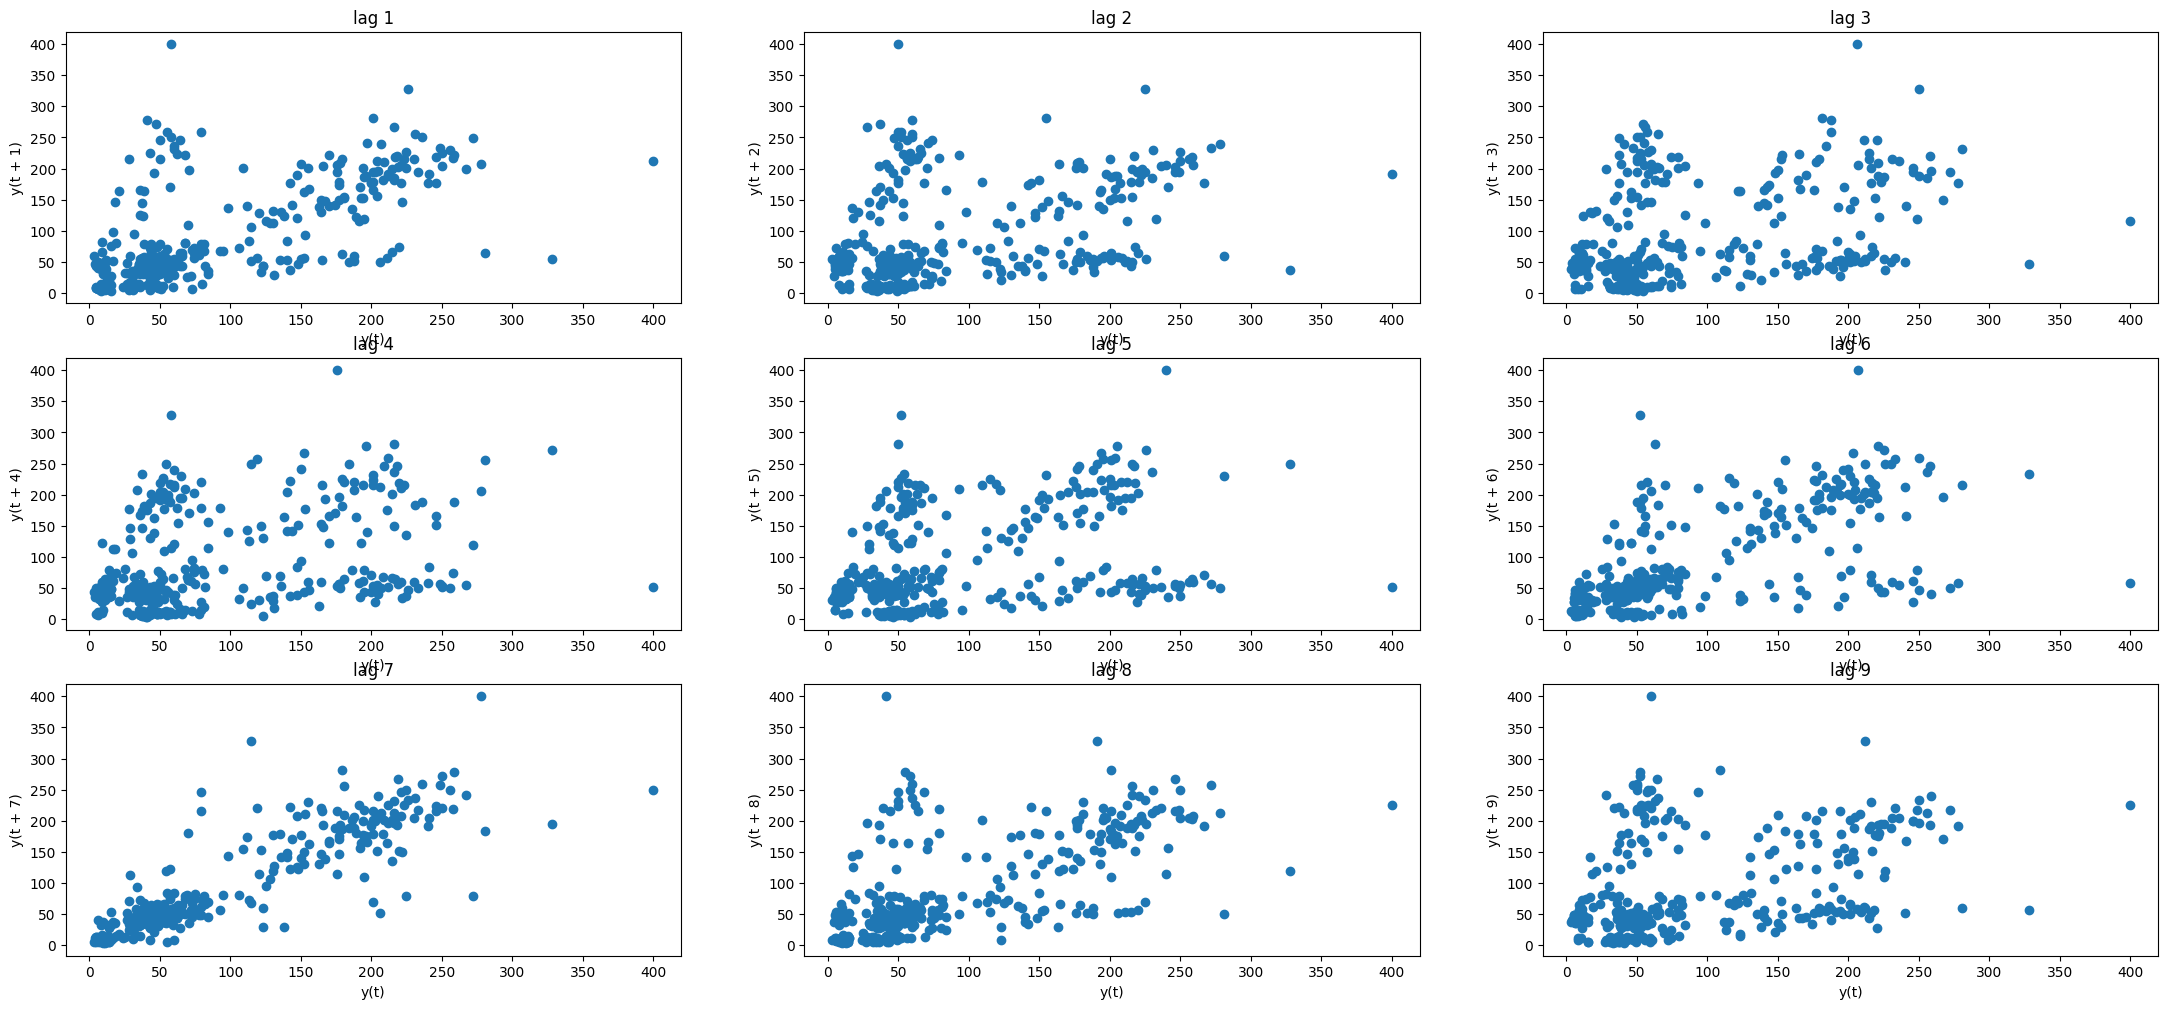

In [ ]:
plot_defasagens(9,3,df['Data'], df['Casos'])